In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import Normal 
from scipy.stats import norm
import matplotlib.dates as mdates 


from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima_process import ArmaProcess 

In [42]:
stoxx500 = pd.read_csv('data/QRM-2025-cw1-data-a(1).csv')
stoxx500.head()

,Date,Adj Close
0,30/10/2013,3040.689941
1,31/10/2013,3067.949951
2,01/11/2013,3052.139893
3,04/11/2013,3061.179932
4,05/11/2013,3035.919922


In [43]:
stoxx500['log_return'] = (np.log(stoxx500['Adj Close']) - np.log(stoxx500['Adj Close'].shift(1)))*100 

In [44]:
lr_features = stoxx500['log_return'].aggregate(['mean', 'skew', 'kurtosis', 'std'])

In [45]:
lr_features

mean         0.011775
skew        -0.795974
kurtosis    10.278073
std          1.239143
Name: log_return, dtype: float64

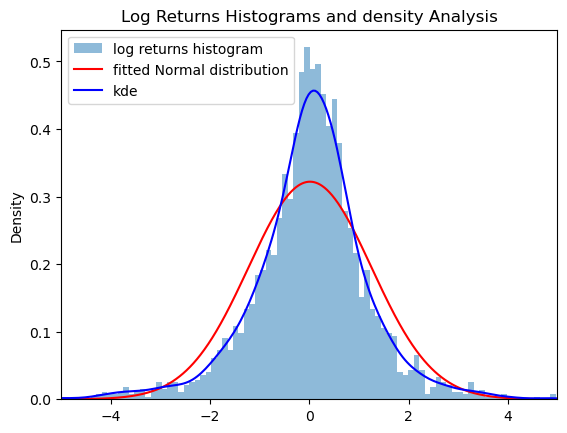

In [46]:
mu, skew, kurt, std = lr_features

figure = plt.Figure(figsize=(12,20))
stoxx500['log_return'].plot(kind='hist', density=True, bins = 200, alpha=0.5, label='log returns histogram')
x_axis = np.linspace(-5, 5, 1000)
pdf = norm.pdf(x_axis, loc=mu, scale=std)
plt.plot(x_axis, pdf, color='red', label='fitted Normal distribution')
stoxx500['log_return'].plot(kind='kde', color='blue', label='kde')
plt.legend()
plt.title('Log Returns Histograms and density Analysis')
plt.xlim(-5, 5)
plt.show()

(i) We can conclude that a fitted normal law is not a good approximation for the stock index. Indeed, the index kde has a kurtosis > 3, resulting in thicker tails, and sharper spike.

In [47]:
stoxx500['abs_returns'] = stoxx500['log_return'].apply(abs)
stoxx500['sq_returns'] = stoxx500['log_return'].apply(lambda x: x**2)
stoxx500.head()

,Date,Adj Close,log_return,abs_returns,sq_returns
0,30/10/2013,3040.689941,NaN,NaN,NaN
1,31/10/2013,3067.949951,0.892513,0.892513,0.796579
2,01/11/2013,3052.139893,-0.516662,0.516662,0.266940
3,04/11/2013,3061.179932,0.295749,0.295749,0.087468
4,05/11/2013,3035.919922,-0.828596,0.828596,0.686571


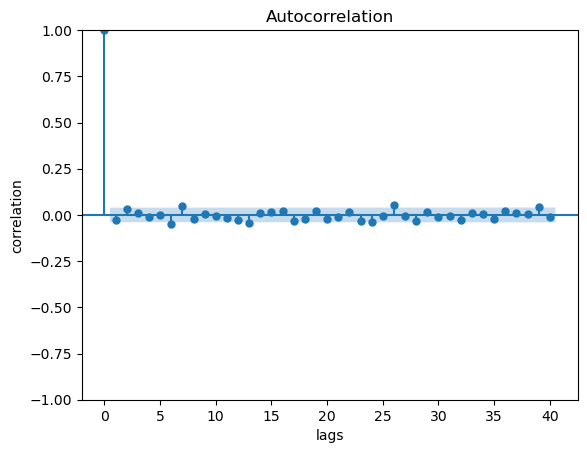

In [48]:
x = stoxx500['log_return'].dropna()
plot_acf(x, lags=40) 
plt.xlabel("lags")
plt.ylabel("correlation")
plt.show()

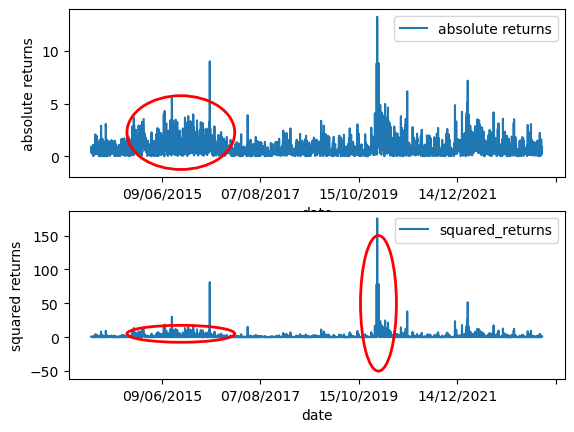

In [49]:
import matplotlib.patches as patches
import matplotlib.dates as mdates 



plt.subplot(2, 1, 1)
x = stoxx500['Date']
y = stoxx500['abs_returns']
plt.plot(x, y, label='absolute returns')
ax1 = plt.gca()
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=18))



ellipse = patches.Ellipse((500, 2.25),
                          width=600,       
                          height=7,     
                          angle=0,      
                          color='red',
                          fill=False,
                          linewidth=2,
                          zorder=5)
ax1.add_patch(ellipse)
plt.ylabel('absolute returns')
plt.xlabel("date")
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(x, stoxx500['sq_returns'], label='squared_returns')

ax2 = plt.gca()

ellipse = patches.Ellipse((500, 5),
                          width=600,       
                          height=25,     
                          angle=0,      
                          color='red',
                          fill=False,
                          linewidth=2,
                          zorder=5)
ellipse2 = patches.Ellipse((1600, 50),
                          width=200,     
                          height=200,   
                          angle=0,      
                          color='red', 
                          fill=False,
                          linewidth=2,
                          zorder=5)
ax2.add_patch(ellipse)
ax2.add_patch(ellipse2)
plt.ylabel('squared returns')
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
plt.xlabel("date")

plt.legend()
plt.show()



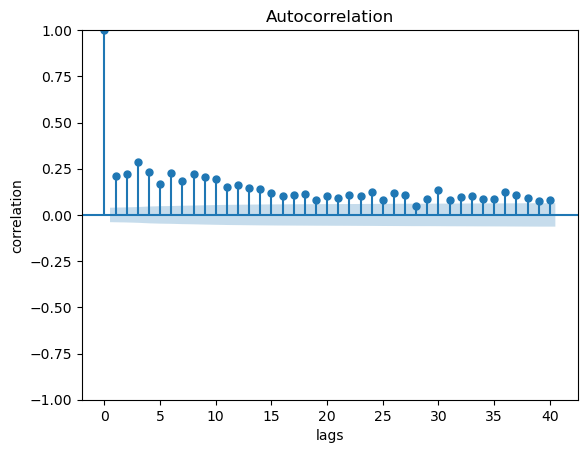

In [50]:
plot_acf(stoxx500['abs_returns'].dropna(), lags=40) 
plt.xlabel("lags")
plt.ylabel("correlation")
plt.show()

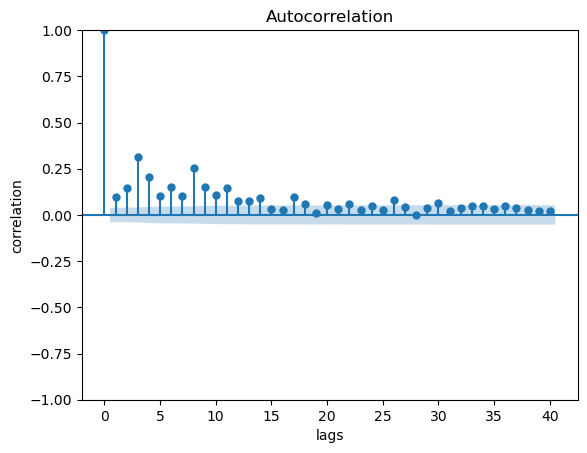

In [51]:
plot_acf(stoxx500['sq_returns'].dropna(), lags=40) 
plt.xlabel("lags")
plt.ylabel("correlation")
plt.show()

In [52]:
import arch
from arch import arch_model

In [53]:
x = stoxx500['log_return'].dropna()
garch11 = arch_model(x, vol='Garch', p=1, q=1, dist='normal', mean='Constant')
garch11_fit = garch11.fit(disp='off')
print(garch11_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3738.92
Distribution:                  Normal   AIC:                           7485.84
Method:            Maximum Likelihood   BIC:                           7509.14
                                        No. Observations:                 2505
Date:                Thu, Nov 20 2025   Df Residuals:                     2504
Time:                        20:27:34   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0476  2.019e-02      2.360  1.830e-02 [8.

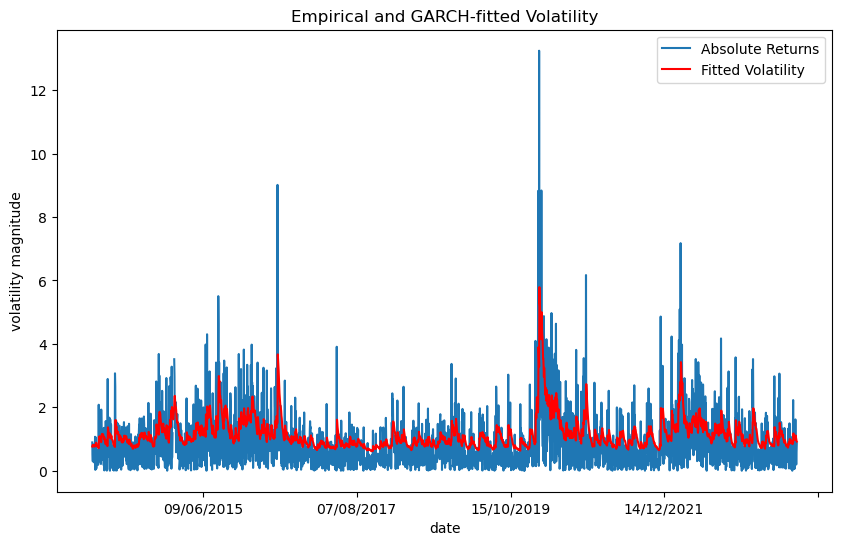

In [54]:
plt.figure(figsize=(10,6))
plt.plot(stoxx500["Date"],stoxx500['abs_returns'], label='Absolute Returns')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=18))

plt.plot(garch11_fit.conditional_volatility, label='Fitted Volatility', color='red')
plt.title('Empirical and GARCH-fitted Volatility')
plt.xlabel('date')
plt.ylabel('volatility magnitude')
plt.legend()
plt.show()  

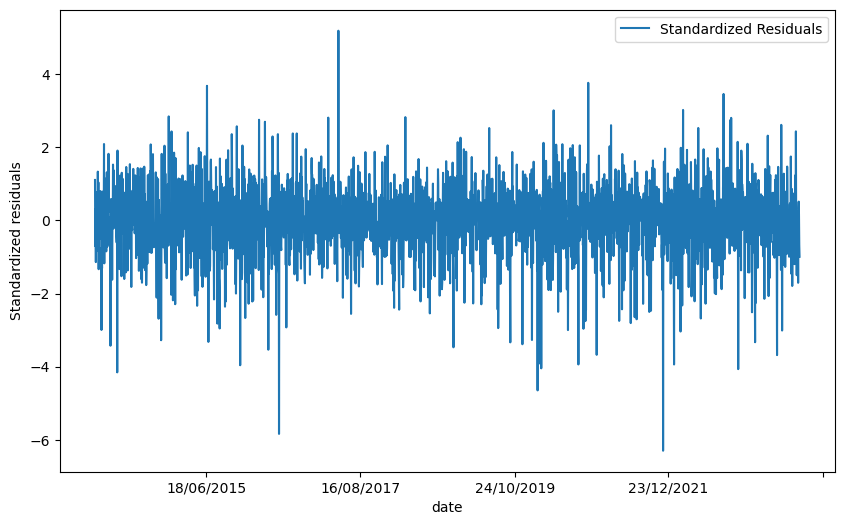

In [55]:
standardized_residuals = garch11_fit.std_resid
squared_residuals = standardized_residuals**2
plt.figure(figsize=(10,6))
plt.plot(stoxx500['Date'].loc[stoxx500['log_return'].notna(),], standardized_residuals, label='Standardized Residuals')
plt.ylabel('Standardized residuals')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
plt.xlabel('date')
plt.legend()
plt.show()

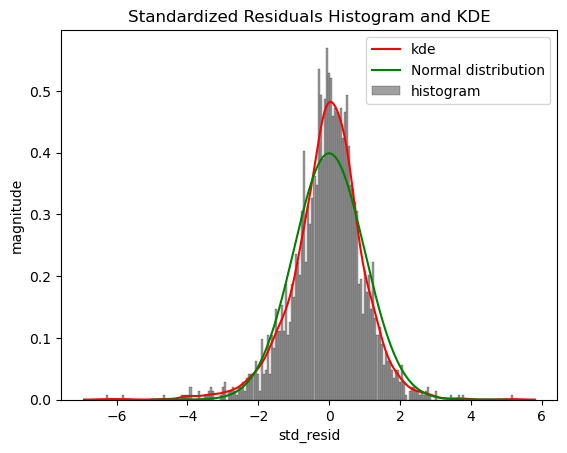

In [56]:
sns.histplot(
    standardized_residuals,
    bins=200,
    stat='density',
    color='grey',
    label='histogram'
)
sns.kdeplot(standardized_residuals, color='red', label='kde')
x_axis = np.linspace(-5, 5, 1000)
pdf = norm.pdf(x_axis, loc=0, scale=1)
plt.plot(x_axis, pdf, color='green', label='Normal distribution')
plt.legend()
plt.ylabel("magnitude")
plt.title('Standardized Residuals Histogram and KDE')
plt.show()

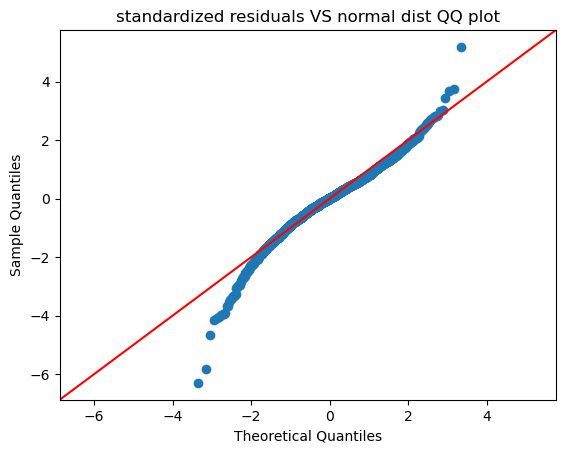

In [57]:
import statsmodels.api as sm
sm.qqplot(standardized_residuals, line ='45')
plt.title('standardized residuals VS normal dist QQ plot')
plt.show()

In [58]:
# ARMA - GARCH(1,1)
prelim_model = arch_model(x, mean='AR', lags=1, vol='Garch', p=1, q=1)
prelim_res = prelim_model.fit(disp='off')
resid_exog = prelim_res.resid.shift(1).dropna()

aligned_x = x.loc[resid_exog.index]

arma_garch = arch_model(aligned_x, x=resid_exog, mean='ARX', lags=1, 
                        vol='Garch', p=1, q=1, dist='t')

                             AR-X - GARCH Model Results                             
Dep. Variable:                   log_return   R-squared:                      -0.002
Mean Model:                            AR-X   Adj. R-squared:                 -0.003
Vol Model:                            GARCH   Log-Likelihood:               -3635.35
Distribution:      Standardized Student's t   AIC:                           7284.70
Method:                  Maximum Likelihood   BIC:                           7325.47
                                              No. Observations:                 2502
Date:                      Thu, Nov 20 2025   Df Residuals:                     2499
Time:                              20:27:35   Df Model:                            3
                                  Mean Model                                  
                    coef    std err          t      P>|t|     95.0% Conf. Int.
-----------------------------------------------------------------------------

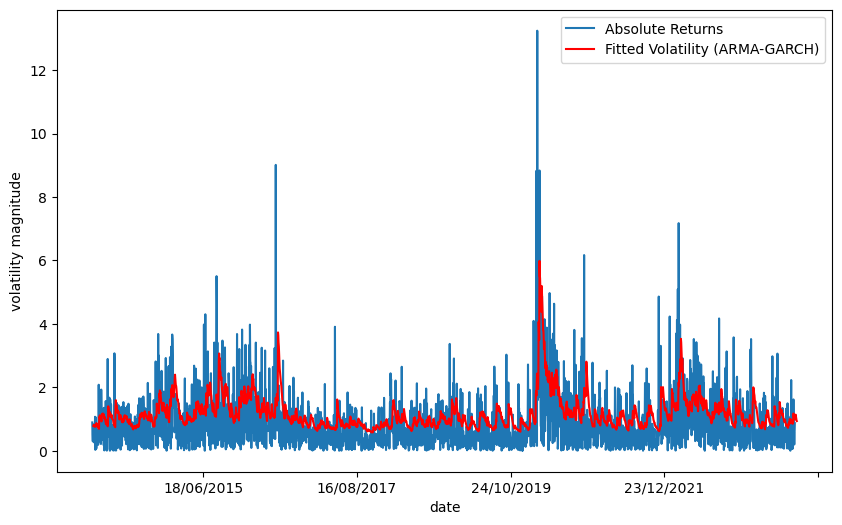

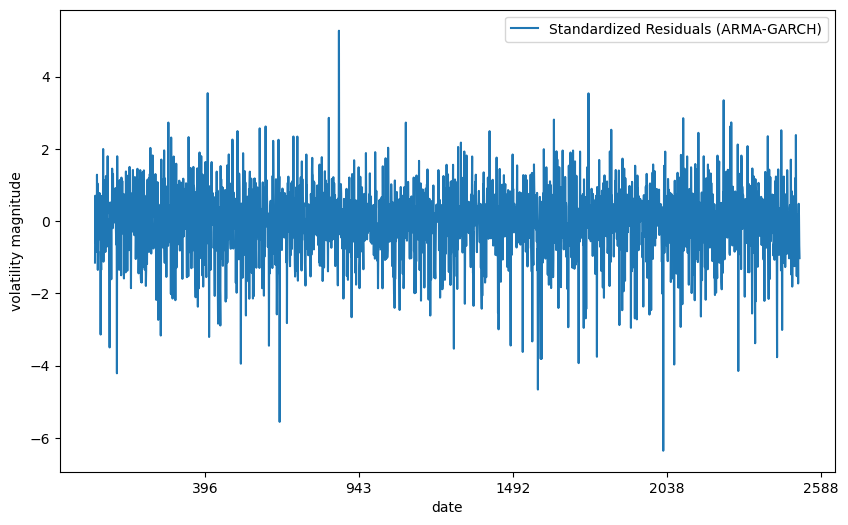

In [59]:
arma_garch_fit = arma_garch.fit(disp='off')
print(arma_garch_fit.summary())
plt.figure(figsize=(10,6))
plt.plot(stoxx500['Date'].loc[stoxx500['abs_returns'].notna(),], stoxx500['abs_returns'].loc[stoxx500['abs_returns'].notna(),], label='Absolute Returns')
plt.plot(arma_garch_fit.conditional_volatility, label='Fitted Volatility (ARMA-GARCH)', color='red')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
plt.legend()
plt.ylabel('volatility magnitude')
plt.xlabel('date')
plt.show()

arma_standardized_residuals = arma_garch_fit.std_resid
plt.figure(figsize=(10,6))
plt.plot(arma_standardized_residuals, label='Standardized Residuals (ARMA-GARCH)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
plt.xlabel('date')
plt.ylabel('volatility magnitude')
plt.legend()
plt.show()  

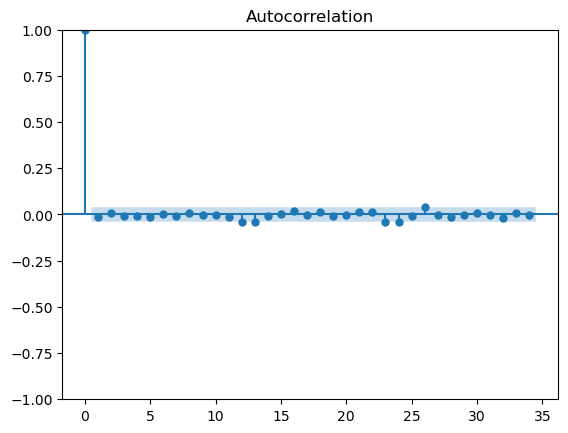

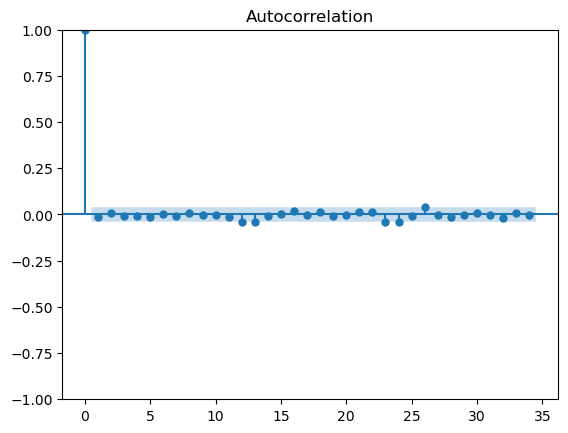

In [60]:
plot_acf(standardized_residuals)

# Part B

In [61]:
dfB = pd.read_csv('data/QRM-2025-cw1-data-b(1).csv')
dfB.head()

,Date,Adj Close
0,30/10/2013,105.445374
1,31/10/2013,105.823196
2,01/11/2013,105.407578
3,04/11/2013,105.256462
4,05/11/2013,105.407578


# HS

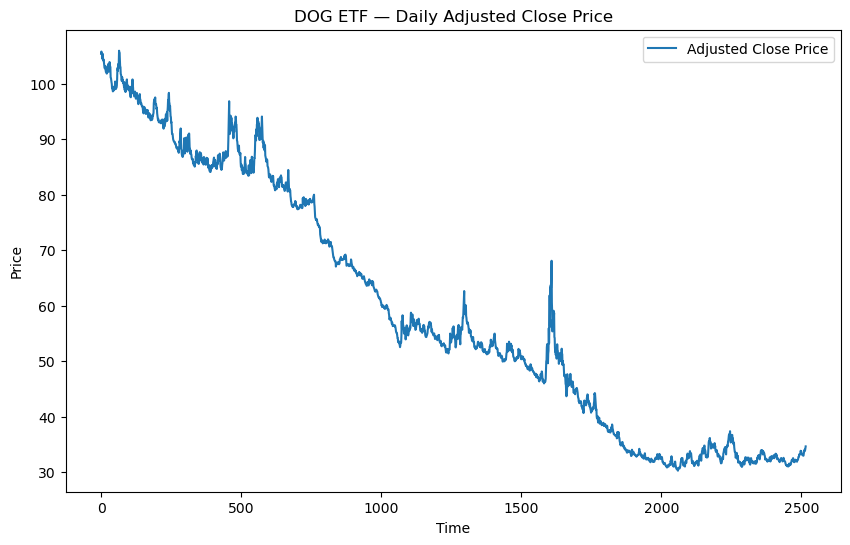

In [62]:
plt.figure(figsize=(10,6))
plt.plot(dfB['Adj Close'], label='Adjusted Close Price')
plt.title('DOG ETF — Daily Adjusted Close Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [63]:
window_size = 500
confidence_level = 0.95
var_hs = []
for i in range(window_size, len(dfB)):
    past_losses = dfB['loss'].iloc[i-window_size:i].dropna()
    var = np.percentile(past_losses, confidence_level * 100)
    var_hs.append(var)

confidence_level = 0.99
var_hs_99 = []
for i in range(window_size, len(dfB)):
    past_losses = dfB['loss'].iloc[i-window_size:i].dropna()
    var = np.percentile(past_losses, confidence_level * 100)
    var_hs_99.append(var)  

KeyError: 'loss'

In [ ]:
confidence_level = 0.95
ef_hs_95 = []

for i in range(window_size, len(dfB)):
    past_losses = dfB['loss'].iloc[i-window_size:i].dropna()
    es = past_losses[past_losses >= var_hs[i - window_size]].mean()
    ef_hs_95.append(es)

ef_hs_99 = []
for i in range(window_size, len(dfB)):
    past_losses = dfB['loss'].iloc[i-window_size:i].dropna()
    es = past_losses[past_losses >= var_hs_99[i - window_size]].mean()
    ef_hs_99.append(es)

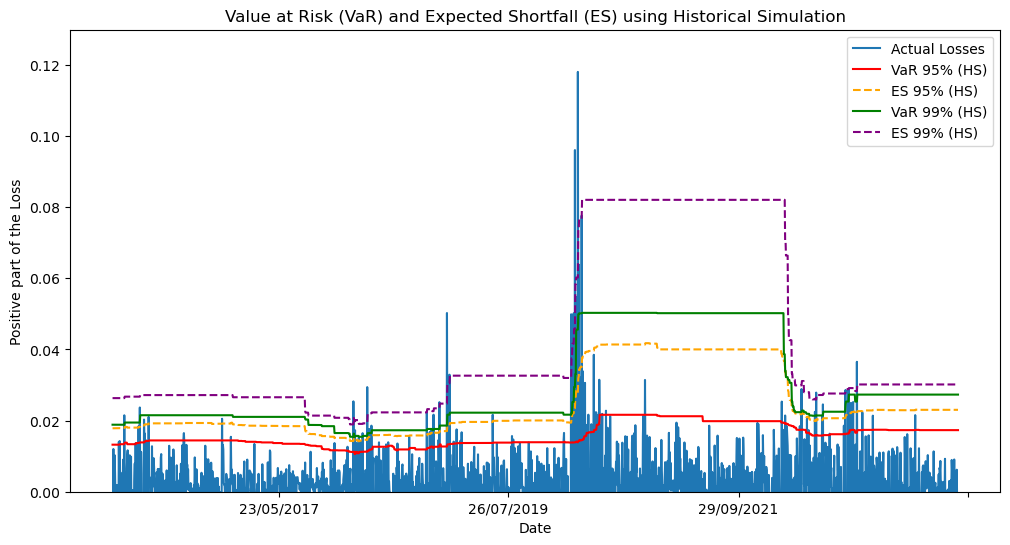

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(dfB.Date[window_size:], dfB['loss'].iloc[window_size:], label='Actual Losses')
plt.plot(dfB.Date[window_size:], var_hs, label='VaR 95% (HS)', color='red')
plt.plot(dfB.Date[window_size:], ef_hs_95, label='ES 95% (HS)', color='orange', linestyle='--')
plt.plot(dfB.Date[window_size:], var_hs_99, label='VaR 99% (HS)', color='green')
plt.plot(dfB.Date[window_size:], ef_hs_99, label='ES 99% (HS)', color='purple', linestyle='--')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
plt.title('Value at Risk (VaR) and Expected Shortfall (ES) using Historical Simulation')
plt.xlabel('Date')
plt.ylabel('Positive part of the Loss')
plt.ylim(0)
plt.legend()
plt.show()

# FHS

In [ ]:

lambda_ = 0.94
dfB['ewma_variance'] = 0.0
dfB['ewma_variance'].iloc[window_size] = dfB['loss'].iloc[:window_size].var()
for t in range(window_size + 1, len(dfB)):
    dfB['ewma_variance'].iloc[t] = (lambda_ * dfB['ewma_variance'].iloc[t-1] + 
                                    (1 - lambda_) * (dfB['loss'].iloc[t-1] ** 2))   

confidence_level = 0.95
var_ewma = []
ef_ewma_95 = []
for i in range(window_size, len(dfB)):
    sigma_t = np.sqrt(dfB['ewma_variance'].iloc[i])
    var = stats.norm.ppf(confidence_level) * sigma_t
    var_ewma.append(var)
    past_losses = dfB['loss'].iloc[i-window_size:i].dropna()
    es = past_losses[past_losses >= var_ewma[i - window_size]].mean()
    ef_ewma_95.append(es)


confidence_level = 0.99
var_ewma_99 = []
ef_ewma_99 = []
for i in range(window_size, len(dfB)):
    sigma_t = np.sqrt(dfB['ewma_variance'].iloc[i])
    var = stats.norm.ppf(confidence_level) * sigma_t
    var_ewma_99.append(var)
    past_losses = dfB['loss'].iloc[i-window_size:i].dropna()
    es = past_losses[past_losses >= var_ewma_99[i - window_size]].mean()
    ef_ewma_99.append(es)



C:\Users\ilias\AppData\Local\Temp\ipykernel_34040\824137072.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfB['ewma_variance'].iloc[window_size] = dfB['loss'].iloc[:window_size].var()
C:\Users\ilias\AppData\Local\Temp\ipykernel_34040\824137072.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfB['ewma_variance'].iloc[t] = (lambda_ * dfB['ewma_variance'].iloc[t-1] +
C:\Users\ilias\AppData\Local\Temp\ipykernel_34040\824137072.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

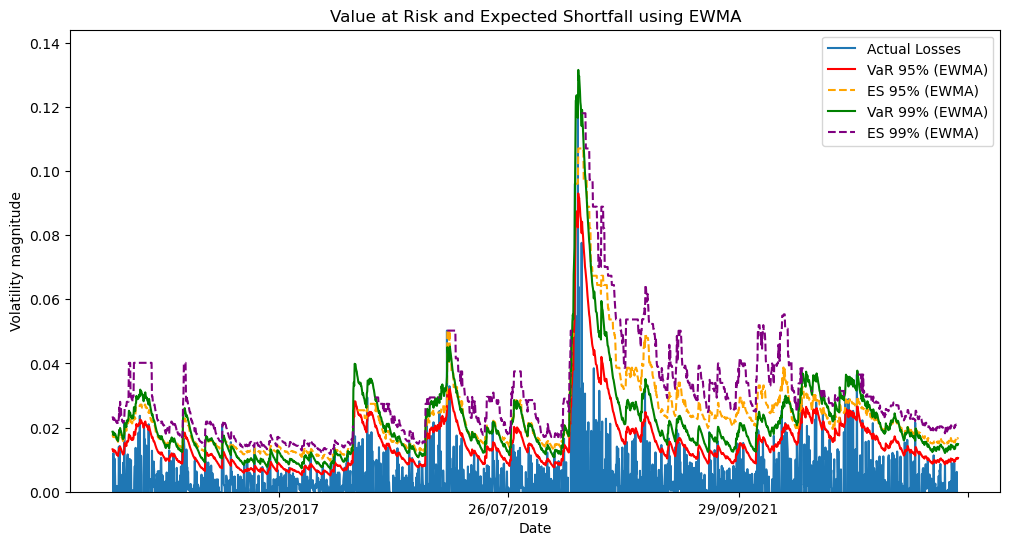

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(dfB.Date[window_size:], dfB['loss'].iloc[window_size:], label='Actual Losses')
plt.plot(dfB.Date[window_size:], var_ewma, label='VaR 95% (EWMA)', color='red')
plt.plot(dfB.Date[window_size:], ef_ewma_95, label='ES 95% (EWMA)', color='orange', linestyle='--')
plt.plot(dfB.Date[window_size:], var_ewma_99, label='VaR 99% (EWMA)', color='green')
plt.plot(dfB.Date[window_size:], ef_ewma_99, label='ES 99% (EWMA)', color='purple', linestyle='--')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=18))

plt.title('Value at Risk and Expected Shortfall using EWMA')
plt.ylim(0)
plt.ylabel('Volatility magnitude')
plt.xlabel('Date')
plt.legend()
plt.show()

# GARCH

In [ ]:
sigmas = []
Zs = []
means = []

loss = dfB['loss'].dropna()
window = 500

for t in range(window, len(loss)):
    serie = loss.iloc[t-window:t]     
    
    model = arch_model(serie, vol='Garch', p=1, q=1,
                       dist='normal', mean='Constant')
    res = model.fit(disp='off')
    
    sigmas.append(res.conditional_volatility.iloc[-1])
    
    z = res.std_resid.iloc[-1]
    Zs.append(z)
    means.append(res.params['mu'])

dfB.loc[loss.index[window:], 'sigma_t'] = sigmas
dfB.loc[loss.index[window:], 'Z_t'] = Zs
dfB.loc[loss.index[window:], 'mu_t'] = means


c:\Users\ilias\anaconda3\envs\qrm\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.443e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
c:\Users\ilias\anaconda3\envs\qrm\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.442e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
c:\Users\ilias\anaconda3\envs\qrm\Li

In [ ]:
dfB['mu_t'][501]

np.float64(0.0007487867355828333)

In [ ]:
#estimating VaR and ES 
alpha_95 = 0.95
alpha_99 = 0.99
quantile95 = dfB['Z_t'].quantile(alpha_95)
quantile99 = dfB['Z_t'].quantile(alpha_99)

dfB['VaR_95_GARCH'] = dfB['mu_t'] + dfB['sigma_t'] * quantile95
dfB['VaR_99_GARCH'] = dfB['mu_t'] + dfB['sigma_t'] * quantile99
dfB['ES_95_GARCH'] = dfB['mu_t'] + dfB['sigma_t'] * dfB['Z_t'][dfB['Z_t'] >= quantile95].mean()
dfB['ES_99_GARCH'] = dfB['mu_t'] + dfB['sigma_t'] * dfB['Z_t'][dfB['Z_t'] >= quantile99].mean()

In [ ]:
dfB['VaR_95_GARCH'][500:]

500          NaN
501     0.014572
502     0.012998
503     0.011878
504     0.013130
          ...   
2511    0.010845
2512    0.010972
2513    0.011008
2514    0.010958
2515    0.010789
Name: VaR_95_GARCH, Length: 2016, dtype: float64

In [ ]:
dfB.iloc[500:,]

,Date,Adj Close,log_returns_B,loss,ewma_variance,sigma_t
500,26/10/2015,85.232819,0.001775,-0.001775,0.000065,0.009550
501,27/10/2015,85.459496,0.002656,-0.002656,0.000061,0.008454
502,28/10/2015,84.439423,-0.012008,0.012008,0.000058,0.007673
503,29/10/2015,84.552757,0.001341,-0.001341,0.000063,0.008543
504,30/10/2015,85.043892,0.005792,-0.005792,0.000059,0.007648
...,...,...,...,...,...,...
2511,23/10/2023,34.049999,0.006186,-0.006186,0.000041,0.007719
2512,24/10/2023,33.840000,-0.006186,0.006186,0.000041,0.007711
2513,25/10/2023,33.959999,0.003540,-0.003540,0.000040,0.007703
2514,26/10/2023,34.250000,0.008503,-0.008503,0.000039,0.007604


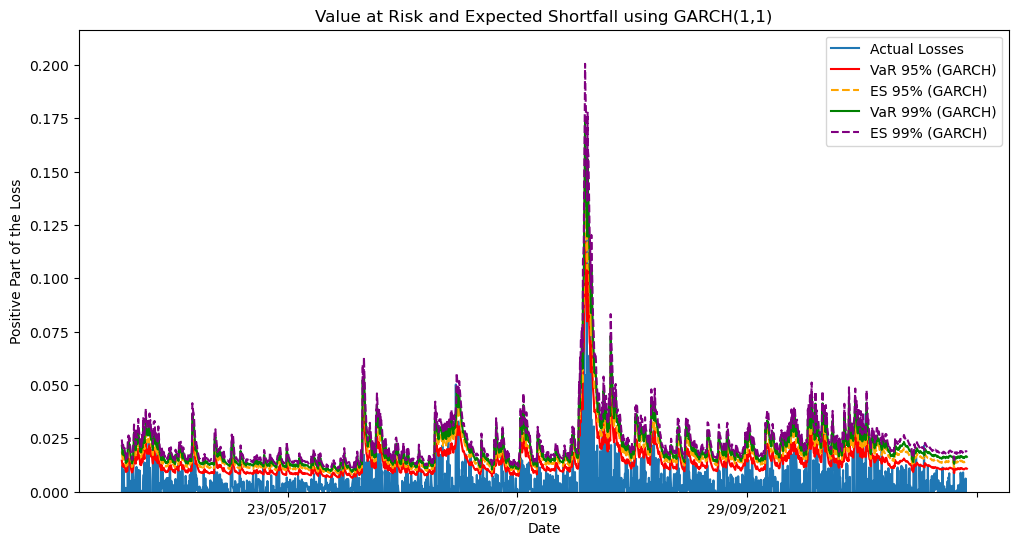

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(dfB.Date[window_size:], dfB['loss'].iloc[window_size:], label='Actual Losses')
plt.plot(dfB.Date[window_size:], dfB['VaR_95_GARCH'].iloc[window_size:], label='VaR 95% (GARCH)', color='red')
plt.plot(dfB.Date[window_size:], dfB['ES_95_GARCH'].iloc[window_size:], label='ES 95% (GARCH)', color='orange', linestyle='--')
plt.plot(dfB.Date[window_size:], dfB['VaR_99_GARCH'].iloc[window_size:], label='VaR 99% (GARCH)', color='green')
plt.plot(dfB.Date[window_size:], dfB['ES_99_GARCH'].iloc[window_size:], label='ES 99% (GARCH)', color='purple', linestyle='--')
plt.title('Value at Risk and Expected Shortfall using GARCH(1,1)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=18))
plt.xlabel('Date')
plt.ylabel('Positive Part of the Loss')
plt.ylim(0)
plt.legend()
plt.show()

In [ ]:
dfB.loc[loss.index[window-1:], 'VaR_hs_95'] = var_hs
dfB.loc[loss.index[window-1:], 'VaR_hs_99'] = var_hs_99
dfB.loc[loss.index[window-1:], 'ES_hs_95'] = ef_hs_95
dfB.loc[loss.index[window-1:], 'ES_hs_99'] = ef_hs_99
dfB.loc[loss.index[window-1:], 'VaR_ewma_95'] = var_ewma
dfB.loc[loss.index[window-1:], 'VaR_ewma_99'] = var_ewma_99
dfB.loc[loss.index[window-1:], 'ES_ewma_95'] = ef_ewma_95
dfB.loc[loss.index[window-1:], 'ES_ewma_99'] = ef_ewma_99

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

def kupiec_pof_test(loss, var_forecasts, alpha, verbose=True):
    """
    Test de Kupiec (Unconditional Coverage).
    LR_uc = -2 * ln( L(p=alpha) / L(p=observed) )
    """

    if isinstance(loss, pd.Series): loss = loss.values
    if isinstance(var_forecasts, pd.Series): var_forecasts = var_forecasts.values
        
    exceptions = (loss > var_forecasts).astype(int)
    n_total = len(exceptions)
    n_exceptions = np.sum(exceptions)
    
    p_obs = n_exceptions / n_total

    if n_exceptions == 0:
        lr_stat = -2 * np.log((1 - alpha)**n_total)
    else:
        log_L0 = (n_total - n_exceptions) * np.log(1 - alpha) + n_exceptions * np.log(alpha)
        log_L1 = (n_total - n_exceptions) * np.log(1 - p_obs) + n_exceptions * np.log(p_obs)
        
        lr_stat = -2 * (log_L0 - log_L1)
    
    p_value = 1 - chi2.cdf(lr_stat, 1)
    reject_h0 = p_value < 0.05

    if verbose:
        print(f"--- Test de Kupiec (Couverture Inconditionnelle) ---")
        print(f"Exceptions: {n_exceptions}/{n_total} ({p_obs:.2%}) | Attendu: {alpha:.2%}")
        print(f"LR.uc: {lr_stat:.3f} | P-value: {p_value:.3f}")
        print(f"Résultat: {'REJET H0 (Modèle invalide)' if reject_h0 else 'H0 Acceptée (Modèle valide)'}")
    
    return lr_stat, p_value, reject_h0

def christoffersen_test(loss, var_forecasts, alpha):
    """
    Test de Christoffersen (Conditional Coverage).
    Test combiné : Indépendance + Couverture Inconditionnelle.
    LR_cc = LR_uc + LR_ind
    """
    if isinstance(loss, pd.Series): loss = loss.values
    if isinstance(var_forecasts, pd.Series): var_forecasts = var_forecasts.values
    
    exceptions = (loss > var_forecasts).astype(int)
    
    I_curr = exceptions[1:]
    I_prev = exceptions[:-1]
    
    n00 = np.sum((I_prev == 0) & (I_curr == 0))
    n01 = np.sum((I_prev == 0) & (I_curr == 1))
    n10 = np.sum((I_prev == 1) & (I_curr == 0))
    n11 = np.sum((I_prev == 1) & (I_curr == 1))
    
    pi_01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    
    pi_11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    
    pi_obs = (n01 + n11) / (n00 + n01 + n10 + n11)
    
    
    def safe_log_term(n, p):
        return n * np.log(p) if (n > 0 and p > 0) else 0

    log_L_restr = safe_log_term(n00 + n10, 1 - pi_obs) + safe_log_term(n01 + n11, pi_obs)
    
    log_L_unrestr = (safe_log_term(n00, 1 - pi_01) + safe_log_term(n01, pi_01) +
                     safe_log_term(n10, 1 - pi_11) + safe_log_term(n11, pi_11))
    
    lr_ind = -2 * (log_L_restr - log_L_unrestr)
    
    
    lr_uc, _, _ = kupiec_pof_test(loss, var_forecasts, alpha, verbose=False)
    
    lr_cc = lr_uc + lr_ind
    
    p_value_cc = 1 - chi2.cdf(lr_cc, 2)
    reject_h0_cc = p_value_cc < 0.05
    
    print(f"\n--- Test de Christoffersen (Couverture Conditionnelle) ---")
    print(f"LR.ind (Indépendance): {lr_ind:.3f}")
    print(f"LR.uc (Kupiec): {lr_uc:.3f}")
    print(f"LR.cc (Combiné): {lr_cc:.3f} | P-value: {p_value_cc:.3f}")
    print(f"Résultat: {'REJET H0 (Clustering de volatilité ou mauvaise VaR)' if reject_h0_cc else 'H0 Acceptée (Indépendance & Couverture OK)'}")
    
    return lr_cc, p_value_cc, reject_h0_cc

In [ ]:
kupiec_pof_test(dfB['loss'].iloc[window_size:], dfB['VaR_95_GARCH'].iloc[window_size:], 0.05)

--- Test de Kupiec (Couverture Inconditionnelle) à 95% ---
Nombre total d'observations: 2016
Nombre de violations (exceptions): 107
Proportion de violations attendue: 5.00%
Proportion de violations observée: 5.31%
Statistique du test (LR.uc): 0.394
P-value: 0.530
Rejeter H0 (le modèle est incorrect) ? Non


(np.float64(0.39385517281711285), np.float64(0.5302798883866895), np.False_)

In [ ]:
kupiec_pof_test(dfB['loss'].iloc[window_size:], dfB['VaR_hs_95'].iloc[window_size:], 0.05)

--- Test de Kupiec (Couverture Inconditionnelle) à 95% ---
Nombre total d'observations: 2016
Nombre de violations (exceptions): 99
Proportion de violations attendue: 5.00%
Proportion de violations observée: 4.91%
Statistique du test (LR.uc): 0.034
P-value: 0.854
Rejeter H0 (le modèle est incorrect) ? Non


(np.float64(0.03402711005150008), np.float64(0.8536491628182403), np.False_)

In [ ]:
christoffersen_test(dfB['loss'].iloc[window_size:], dfB['VaR_99_GARCH'].iloc[window_size:], 0.01)


--- Test de Christoffersen (Couverture Conditionnelle) ---
LR.ind (Indépendance): 0.362
LR.uc (Kupiec): 0.069
LR.cc (Combiné): 0.430 | P-value: 0.806
Résultat: H0 Acceptée (Indépendance & Couverture OK)


(np.float64(0.430467348210243), np.float64(0.806352994346363), np.False_)